# MODELIZACIÓN CLASIFICACIÓN PROBABILITY OF DEFAULT

## IMPORTAR PAQUETES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt
from yellowbrick.classifier import discrimination_threshold

#Autocompletar rápido
%config IPCompleter.greedy=True

#Desactivar la notación científica
pd.options.display.float_format = '{:.2f}'.format

#Desactivar los warnings
import warnings
warnings.filterwarnings("ignore")

## IMPORTAR LOS DATOS

In [2]:
ruta_proyecto = 'C:/Users/Google Drive/DS4B/CursoMachineLearningPython/03_MACHINE_LEARNING/08_CASOS/03_RIESGOS'

In [3]:
nombre = 'df_tablon_pd.pickle'

In [4]:
df = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre)

In [5]:
x = df.drop(columns='target_pd')
y = df.target_pd

## MODELIZAR

### Reservar el dataset de validacion

In [6]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### Crear el pipe y el diccionario de algorimos, parámetros y valores a testar

Modificar para dejar solo los algoritmos que se quieran testar.

Modificar los parámetros.

In [7]:
pipe = Pipeline([('algoritmo',LogisticRegression())])

grid = [{'algoritmo': [LogisticRegression(solver = 'saga', n_jobs=-1)],
         'algoritmo__penalty': ['elasticnet', 'l1', 'l2'],
         'algoritmo__C': [0,0.25,0.5,0.75,1]}
       ]

### Optimizar los hiper parámetros

####  Con grid search

In [8]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 5, 
                           scoring = 'roc_auc',
                           verbose = 0,
                           n_jobs = -1)

modelo = grid_search.fit(train_x,train_y)

In [9]:
salida = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').reset_index(drop=True).head(5)
salida

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo,param_algoritmo__C,param_algoritmo__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.97,1.43,0.01,0.01,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",1,l1,"{'algoritmo': LogisticRegression(C=1, n_jobs=-...",0.70,0.70,0.70,0.70,0.70,0.70,0.00,1
1,12.41,0.58,0.02,0.00,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",0.75,l1,"{'algoritmo': LogisticRegression(C=1, n_jobs=-...",0.70,0.70,0.70,0.70,0.70,0.70,0.00,2
2,11.13,2.09,0.02,0.00,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",0.50,l1,"{'algoritmo': LogisticRegression(C=1, n_jobs=-...",0.70,0.70,0.70,0.70,0.70,0.70,0.00,3
3,8.38,0.66,0.01,0.01,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",1,l2,"{'algoritmo': LogisticRegression(C=1, n_jobs=-...",0.70,0.70,0.70,0.70,0.70,0.70,0.00,4
4,9.89,1.08,0.02,0.00,"LogisticRegression(C=1, n_jobs=-1, penalty='l1...",0.75,l2,"{'algoritmo': LogisticRegression(C=1, n_jobs=-...",0.70,0.70,0.70,0.70,0.70,0.70,0.00,5


Vemos que el resultados del auc es el mismo en todas las primeras configuraciones.

Y reentreamos el modelo con esa configuración.

In [10]:
#Instanciar
rl = LogisticRegression(solver = 'saga', n_jobs=-1, C = 1, penalty = 'l1')

#Entrenar
rl.fit(train_x,train_y)

LogisticRegression(C=1, n_jobs=-1, penalty='l1', solver='saga')

In [11]:
coeficientes = pd.DataFrame(data = rl.coef_, columns = rl.feature_names_in_).stack().droplevel(level = 0).sort_values()
coeficientes

tipo_interes_mms                       -2.42
principal_mms                          -1.37
ingresos_mms                           -1.17
num_cuotas_ 36 months                  -0.27
ingresos_verificados_Not Verified      -0.27
finalidad_house                        -0.24
vivienda_MORTGAGE                      -0.19
finalidad_other                        -0.17
finalidad_car                          -0.14
finalidad_credit_card                  -0.14
vivienda_OWN                           -0.09
finalidad_medical                      -0.06
dti_mms                                -0.04
ingresos_verificados_Source Verified   -0.03
finalidad_debt_consolidation           -0.00
antigüedad_empleo_oe                   -0.00
rating_oe_mms                           0.00
finalidad_vacation                      0.00
num_cuotas_ 60 months                   0.00
antigüedad_empleo_oe_mms                0.00
finalidad_moving                        0.00
finalidad_home_improvement              0.01
vivienda_R

**IMPORTANTE**

Vemos cosas raras como que el signo del principal y del tipo de interés son negativos.

Es decir, según el modelo, cuanto menos importe pidas mayor es el riesgo de default.

O cuanto menor es el tipo de interés aplicado mayor es el riesgo de default.

En una situación real podría pasar, pero al menos se necesitaría una explicación convincente. 

Nosotros aquí lo daremos por bueno y continuamos.

## EVALUAR

### Predecir sobre validación

In [12]:
pred = rl.predict_proba(val_x)[:, 1]

### Evaluar sobre validación

In [13]:
roc_auc_score(val_y, pred)

0.698732180633228

## REPORTING DEL MODELO

### Gain Chart

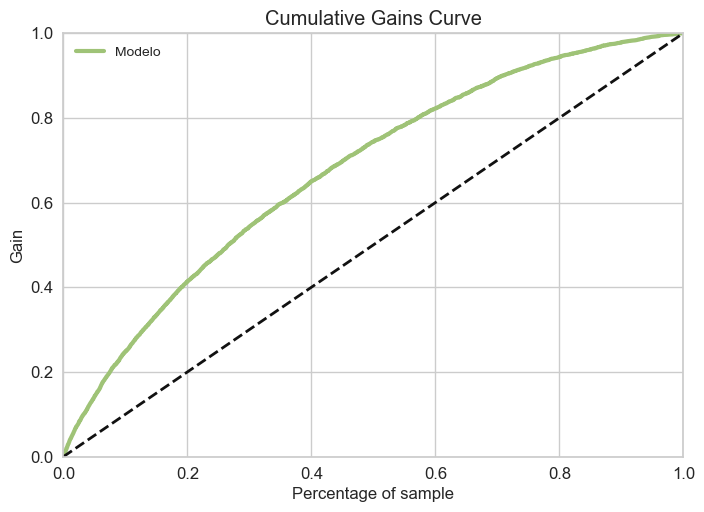

In [14]:
fig, ax = plt.subplots()

skplt.metrics.plot_cumulative_gain(val_y, modelo.best_estimator_.predict_proba(val_x), ax=ax) 

# Eliminamos la línea de los ceros, que internamente tiene etiqueta 'Class 0'
lines = ax.get_lines()
# Buscar por la etiqueta y eliminar la línea correspondiente
for line in lines:
    if line.get_label() == 'Class 0':
        line.remove()

# Personalizamos la leyenda sin incluir la línea de los ceros
plt.legend(labels=['Modelo'])

# Ahora puedes mostrar el gráfico
plt.show()

### Lift Chart

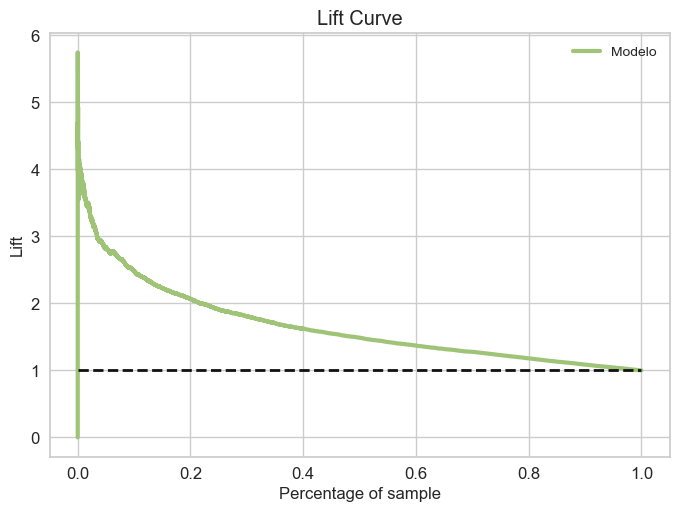

In [15]:
fig, ax = plt.subplots()

skplt.metrics.plot_lift_curve(val_y, modelo.best_estimator_.predict_proba(val_x), ax=ax) 

# Eliminamos la línea de los ceros, que internamente tiene etiqueta 'Class 0'
lines = ax.get_lines()
# Buscar por la etiqueta y eliminar la línea correspondiente
for line in lines:
    if line.get_label() == 'Class 0':
        line.remove()

# Personalizamos la leyenda sin incluir la línea de los ceros
plt.legend(labels=['Modelo'])

# Ahora puedes mostrar el gráfico
plt.show()

### ROC Chart

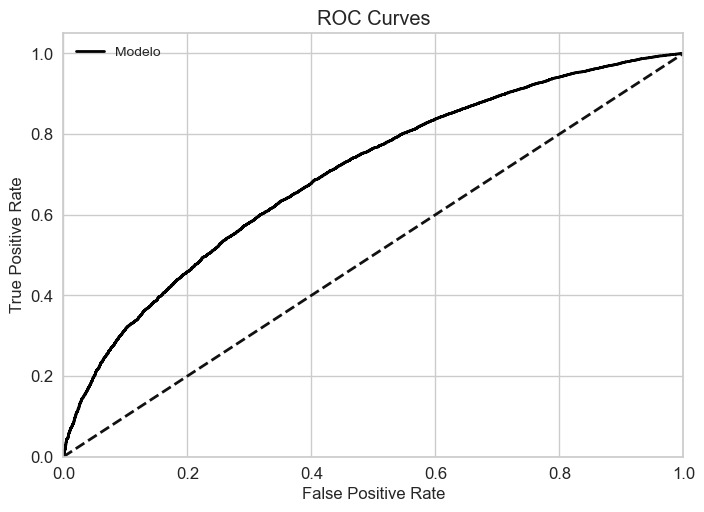

In [17]:
fig, ax = plt.subplots()

# Generamos la gráfica ROC
skplt.metrics.plot_roc(val_y, modelo.best_estimator_.predict_proba(val_x), ax=ax)

# Obtenemos todas las líneas y las leyendas
lines = ax.get_lines()

# Recorremos las líneas para eliminar las no deseadas, excepto la línea de la clase 0
for line in lines:
    if 'ROC curve of class 0' in line.get_label():
        line.set_label('Modelo')
    elif line.get_linestyle() != '--':  # Mantenemos la línea punteada pero sin leyenda
        line.set_visible(False)

# Solo añadimos al leyenda la línea de la clase 0 renombrada a 'Modelo'
handles, labels = ax.get_legend_handles_labels()
new_handles = [h for h, l in zip(handles, labels) if l == 'Modelo']
new_labels = ['Modelo']

ax.legend(new_handles, new_labels, loc='best')


plt.show();